# Wage Gap Prediction

## 1 Import Python Libraries

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sklearn
import matplotlib.pyplot as plt
import sklearn.preprocessing as sp
from  sklearn import feature_selection 
from sklearn import linear_model
from sklearn import metrics
from pandas.stats.api import ols

##2 Load CSVs

In [27]:
gender_data_raw = pd.read_csv('working_data\GenderStat_Data_new.csv',header=None,skiprows=0)

payment_gap_oecd_raw = pd.read_csv('working_data\Payment_gap_oecd.csv', header=None,skiprows = 1)

##3 Travers years and indicator in GenderStats

In [28]:
gender_data_raw.drop(gender_data_raw.columns[[1,3]], axis=1, inplace=True)
gender_data_raw.loc[0,0] = 'country-full-name'

gender_data_raw.columns = gender_data_raw.loc[0]

gender_data_raw = pd.pivot_table(gender_data_raw,index ='country-full-name', columns='Indicator Name')

gender_data_raw = gender_data_raw.stack(level=0)
gender_data_raw.reset_index(inplace=True)
gender_data_raw.rename(columns={0:'Year'},inplace=True)
gender_data_raw.rename(columns={"Indicator Name":'Id'},inplace=True)
gender_data_raw.to_csv("newCsv.csv")


gender_stats_normalized = pd.read_csv("newCsv.csv")
gender_stats_normalized.drop(gender_stats_normalized.columns[[0]], axis=1, inplace=True)
gender_stats_normalized.head()

,country-full-name,Year,"Access to anti-retroviral drugs, female (%)","Access to anti-retroviral drugs, male (%)","Account at a financial institution, female (% age 15+) [ts]","Account at a financial institution, male (% age 15+) [ts]","Adolescent fertility rate (births per 1,000 women ages 15-19)","Age at first marriage, female","Age at first marriage, male",Age dependency ratio (% of working-age population),...,Women who own land both alone and jointly (% of women age 15-49): Q3,Women who own land both alone and jointly (% of women age 15-49): Q4,Women who own land both alone and jointly (% of women age 15-49): Q5 (highest),Women who own land jointly (% of women age 15-49),Women who own land jointly (% of women age 15-49): Q1 (lowest),Women who own land jointly (% of women age 15-49): Q2,Women who own land jointly (% of women age 15-49): Q3,Women who own land jointly (% of women age 15-49): Q4,Women who own land jointly (% of women age 15-49): Q5 (highest),Women who were first married by age 18 (% of women ages 20-24)
0,Australia,1960.0,NaN,NaN,NaN,NaN,44.8286,NaN,NaN,63.356535,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,1961.0,NaN,NaN,NaN,NaN,45.0668,NaN,NaN,63.596913,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Australia,1962.0,NaN,NaN,NaN,NaN,45.3050,NaN,NaN,63.372475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Australia,1963.0,NaN,NaN,NaN,NaN,45.9764,NaN,NaN,62.857899,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Australia,1964.0,NaN,NaN,NaN,NaN,46.6478,NaN,NaN,62.304998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##4 Adding Header to Data Files 

In [29]:
payment_gap_oecd_raw.columns = ['location', 'indicator', 'subject', 'measure', 'frequency', 'Year', 'WageGaP', 
                      'country-full-name']
payment_gap_oecd_raw.head(10)

,location,indicator,subject,measure,frequency,Year,WageGaP,country-full-name
0,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1975,21.582733,Australia
1,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1976,20.754717,Australia
2,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1977,18.390804,Australia
3,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1978,19.791666,Australia
4,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1979,20.000000,Australia
5,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1980,18.750000,Australia
6,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1981,18.253969,Australia
7,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1982,20.819113,Australia
8,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1983,19.155844,Australia
9,AUS,WAGEGAP,TOT,PC_MENWAGE,A,1984,18.674698,Australia


#5 Intersect Countries and merge two csv's

In [30]:
#checking both csv's - country-full-name
#csv's - gender_stats_normalized, payment_gap_oecd_raw
new_data_raw = pd.merge(gender_stats_normalized, payment_gap_oecd_raw, how='inner', on=['country-full-name', 'Year'])
new_data_raw.head(10)

,country-full-name,Year,"Access to anti-retroviral drugs, female (%)","Access to anti-retroviral drugs, male (%)","Account at a financial institution, female (% age 15+) [ts]","Account at a financial institution, male (% age 15+) [ts]","Adolescent fertility rate (births per 1,000 women ages 15-19)","Age at first marriage, female","Age at first marriage, male",Age dependency ratio (% of working-age population),...,Women who own land jointly (% of women age 15-49): Q3,Women who own land jointly (% of women age 15-49): Q4,Women who own land jointly (% of women age 15-49): Q5 (highest),Women who were first married by age 18 (% of women ages 20-24),location,indicator,subject,measure,frequency,WageGaP
0,Australia,1975.0,NaN,NaN,NaN,NaN,38.5016,NaN,NaN,56.816075,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,21.582733
1,Australia,1976.0,NaN,NaN,NaN,NaN,35.1688,22.0,24.4,56.478399,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,20.754717
2,Australia,1977.0,NaN,NaN,NaN,NaN,31.8360,NaN,NaN,55.782389,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.390804
3,Australia,1978.0,NaN,NaN,NaN,NaN,30.6870,NaN,NaN,54.923225,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,19.791666
4,Australia,1979.0,NaN,NaN,NaN,NaN,29.5380,NaN,NaN,54.143916,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,20.000000
5,Australia,1980.0,NaN,NaN,NaN,NaN,28.3890,NaN,NaN,53.550174,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.750000
6,Australia,1981.0,NaN,NaN,NaN,NaN,27.2400,23.5,25.7,52.703024,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.253969
7,Australia,1982.0,NaN,NaN,NaN,NaN,26.0910,NaN,NaN,52.204834,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,20.819113
8,Australia,1983.0,NaN,NaN,NaN,NaN,25.0928,NaN,NaN,51.904419,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,19.155844
9,Australia,1984.0,NaN,NaN,NaN,NaN,24.0946,NaN,NaN,51.574265,...,NaN,NaN,NaN,NaN,AUS,WAGEGAP,TOT,PC_MENWAGE,A,18.674698


##6 Drop unnecessary columns payment_gap_oecd_raw

In [31]:
new_data_raw.drop('subject', axis=1, inplace=True)
new_data_raw.drop('indicator', axis=1, inplace=True)
new_data_raw.drop('location', axis=1, inplace=True)
new_data_raw.drop('frequency', axis=1, inplace=True)
new_data_raw.drop('measure', axis=1, inplace=True)

#thresh is the minimum number of non NAN values
new_data_raw = new_data_raw.dropna(1,thresh = new_data_raw.shape[0] * 90 / 100)

In [7]:
new_data_raw.head(10)

,country-full-name,Year,"Adolescent fertility rate (births per 1,000 women ages 15-19)",Age dependency ratio (% of working-age population),"Age population, age 0, female, interpolated","Age population, age 0, male, interpolated","Age population, age 01, female, interpolated","Age population, age 01, male, interpolated","Age population, age 02, female, interpolated","Age population, age 02, male, interpolated",...,"Self-employed, male (% of males employed)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)","Wage and salaried workers, female (% of females employed)","Wage and salary workers, male (% of males employed)",WageGaP
0,Australia,1975.0,38.5016,56.816075,129221.0,135399.0,126229.0,131931.0,124053.0,129490.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.582733
1,Australia,1976.0,35.1688,56.478399,123159.0,129271.0,128242.0,134262.0,126207.0,131859.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754717
2,Australia,1977.0,31.8360,55.782389,114477.0,120394.0,117271.0,122814.0,127496.0,133349.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390804
3,Australia,1978.0,30.6870,54.923225,105208.0,110885.0,111670.0,117102.0,116783.0,122087.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.791666
4,Australia,1979.0,29.5380,54.143916,98219.0,103715.0,107201.0,112581.0,114299.0,119622.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000
5,Australia,1980.0,28.3890,53.550174,95529.0,100981.0,104981.0,110401.0,112508.0,117925.0,...,17.799999,7.9,5.1,6.1,13.9,11.4,12.500000,87.099998,82.199997,18.750000
6,Australia,1981.0,27.2400,52.703024,98291.0,103710.0,98536.0,104011.0,106417.0,111875.0,...,17.299999,7.4,4.8,5.8,12.9,10.2,11.400000,87.300003,82.699997,18.253969
7,Australia,1982.0,26.0910,52.204834,105328.0,110843.0,108584.0,114060.0,101377.0,106914.0,...,17.400000,8.5,6.4,7.2,14.5,13.3,13.800000,87.300003,82.599998,20.819113
8,Australia,1983.0,25.0928,51.904419,114547.0,120245.0,112786.0,118398.0,112058.0,117621.0,...,17.400000,10.4,9.7,10.0,17.0,19.4,18.299999,87.300003,82.599998,19.155844
9,Australia,1984.0,24.0946,51.574265,122946.0,128844.0,116994.0,122759.0,113107.0,118792.0,...,17.700001,9.5,8.7,9.0,15.9,17.5,16.799999,87.699997,82.300003,18.674698


##7 add 35 binary columns for countries

In [32]:
cols = new_data_raw.columns.tolist()
cols_to_transform = [cols[0]]
binary_countries = pd.get_dummies(data = new_data_raw,columns=cols_to_transform)


cols = binary_countries.columns.tolist()
cols = cols[-32:] + cols[:-32]
binary_countries = binary_countries[cols]
binary_countries.to_csv("Binary.csv")
binary_countries.head()

,country-full-name_Australia,country-full-name_Austria,country-full-name_Belgium,country-full-name_Canada,country-full-name_Chile,country-full-name_Czech Republic,country-full-name_Denmark,country-full-name_Estonia,country-full-name_Finland,country-full-name_France,...,"Self-employed, male (% of males employed)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)","Wage and salaried workers, female (% of females employed)","Wage and salary workers, male (% of males employed)",WageGaP
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.582733
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754717
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390804
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.791666
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000


##8 Specifying Data Types

In [33]:
new_data_raw = binary_countries
cols = binary_countries.columns.tolist()
binary_variables = cols[0:32]
numeric_variables = cols[32:]

##9 Type Conversion - convert all fearutes to float and countries to binaries

In [34]:
# there is no need to convert all other feature to float because it is already in float64 type
new_data_raw[numeric_variables].dtypes

Year                                                                                   float64
Adolescent fertility rate (births per 1,000 women ages 15-19)                          float64
Age dependency ratio (% of working-age population)                                     float64
Age population, age 0, female, interpolated                                            float64
Age population, age 0, male, interpolated                                              float64
Age population, age 01, female, interpolated                                           float64
Age population, age 01, male, interpolated                                             float64
Age population, age 02, female, interpolated                                           float64
Age population, age 02, male, interpolated                                             float64
Age population, age 03, female, interpolated                                           float64
Age population, age 03, male, interpolated        

In [14]:
new_data_raw[binary_variables].dtypes

country-full-name_Australia             float64
country-full-name_Austria               float64
country-full-name_Belgium               float64
country-full-name_Canada                float64
country-full-name_Chile                 float64
country-full-name_Czech Republic        float64
country-full-name_Denmark               float64
country-full-name_Estonia               float64
country-full-name_Finland               float64
country-full-name_France                float64
country-full-name_Germany               float64
country-full-name_Greece                float64
country-full-name_Hungary               float64
country-full-name_Ireland               float64
country-full-name_Japan                 float64
country-full-name_Latvia                float64
country-full-name_Luxembourg            float64
country-full-name_Mexico                float64
country-full-name_Netherlands           float64
country-full-name_New Zealand           float64
country-full-name_Norway                

In [35]:
for variable in binary_variables:
    new_data_raw[variable] = new_data_raw[variable].astype(np.int)
new_data_raw[binary_variables].dtypes
new_data_raw.head()

,country-full-name_Australia,country-full-name_Austria,country-full-name_Belgium,country-full-name_Canada,country-full-name_Chile,country-full-name_Czech Republic,country-full-name_Denmark,country-full-name_Estonia,country-full-name_Finland,country-full-name_France,...,"Self-employed, male (% of males employed)","Unemployment, female (% of female labor force) (national estimate)","Unemployment, male (% of male labor force) (national estimate)","Unemployment, total (% of total labor force) (national estimate)","Unemployment, youth female (% of female labor force ages 15-24) (national estimate)","Unemployment, youth male (% of male labor force ages 15-24) (national estimate)","Unemployment, youth total (% of total labor force ages 15-24) (national estimate)","Wage and salaried workers, female (% of females employed)","Wage and salary workers, male (% of males employed)",WageGaP
0,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.582733
1,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.754717
2,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.390804
3,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.791666
4,1,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.000000


In [36]:
data_no_na = new_data_raw
cols = data_no_na.columns.tolist()
imputed_variables = cols[33:]
for variable in imputed_variables:
    data_no_na[variable].fillna(method='ffill', inplace=True)
    data_no_na[variable].fillna(method='bfill', inplace=True)

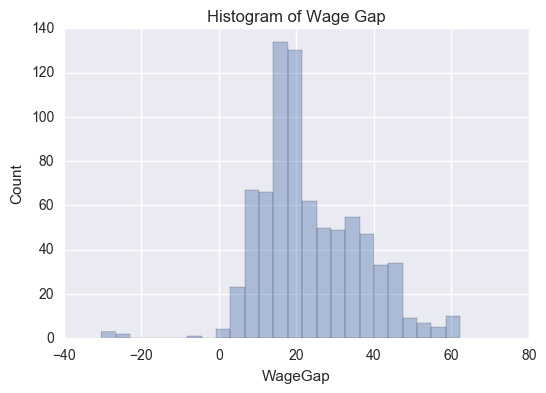

In [37]:
%matplotlib inline
sns.distplot(data_no_na.WageGaP, bins = 25, kde = False)
plt.title('Histogram of Wage Gap')
plt.xlabel('WageGap')
plt.ylabel('Count')
data_no_na.to_csv('data.csv')

In [38]:
# cols = data_no_na .columns.tolist()
# #sort rows by years:
# data_no_na.sort_values(['Year'],ascending=True, inplace=True)
x = data_no_na[list(data_no_na)[:-1]]
data_no_na.to_csv('dana_no_ca.csv')
x.to_csv('x.csv')

split y to train and test by year

In [39]:
y_train = data_no_na[data_no_na['Year'] < 2010]
y_train = y_train['WageGaP']

y_test = data_no_na[data_no_na['Year'] >= 2010]
y_test = y_test['WageGaP']

In [40]:
l = list(data_no_na)
x_normelize = pd.DataFrame(sp.MinMaxScaler().fit_transform(new_data_raw),columns = l)
x_normelize.drop('WageGaP', axis=1, inplace=True)
x_normelize.head()
x_normelize.to_csv('normelizeX.csv')

In [41]:
#train will contain years 1975-2009
#2010 normelized to 0.88
x_train = x_normelize[x_normelize['Year'] < 0.88]
x_test = x_normelize[x_normelize['Year'] >= 0.88]

In [42]:
x_train.to_csv('x_train.csv')
x_test.to_csv('x_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [44]:
print("Computing regularization path using the coordinate descent lasso...")
n_fold_cv = x_train.shape[0]
model = linear_model.LassoCV(eps=1e-2,n_alphas=100, cv=n_fold_cv).fit(x_train,y_train)
#t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 100, 200
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: best alpha is %.3f' %model.alpha_)
plt.axis('tight')
plt.ylim(ymin, ymax)

Computing regularization path using the coordinate descent lasso...


(100, 200)

In [20]:
#coefficients remaining
model.coef_

array([-2.65886045,  5.29073216,  0.        ,  0.61867507, -0.        ,
       -0.        , -3.08774011, -9.93450673,  1.42394583, -0.        ,
        0.        , -0.        , -5.56828236, -2.64524542,  8.03901321,
       -0.        ,  8.60027956, -0.        ,  5.69601796, -2.07353213,
       -2.36884041,  0.        ,  1.49821474,  0.        , -0.        ,
        0.        , -0.        , -3.96647059,  0.90650005,  0.        ,
        6.9812152 ,  0.        , -0.14146213, -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
        0.        , -0.        , -0.        , -1.38266938, -0.        ,
        0.        ,  4.39687053,  0.        , -0.        , -0.  

In [21]:
#get the error
y_hat = model.predict(x_test)
err = metrics.mean_squared_error(y_test,y_hat)
print ('test mse is : %.2f' %err)

182.7817308826103

In [22]:
#remaining features
sfm = feature_selection.SelectFromModel(model, prefit=True)
remaining_features = [list(x_train)[i] for i in sfm.get_support(True)]
print ('The renaming features after lasso selection:')
remaining_features

['country-full-name_Australia',
 'country-full-name_Austria',
 'country-full-name_Canada',
 'country-full-name_Denmark',
 'country-full-name_Estonia',
 'country-full-name_Finland',
 'country-full-name_Hungary',
 'country-full-name_Ireland',
 'country-full-name_Japan',
 'country-full-name_Luxembourg',
 'country-full-name_Netherlands',
 'country-full-name_New Zealand',
 'country-full-name_Norway',
 'country-full-name_Portugal',
 'country-full-name_Sweden',
 'country-full-name_Switzerland',
 'country-full-name_United Kingdom',
 'Year',
 'Fertility rate, total (births per woman)',
 'GDP per capita (Current US$)',
 'Long-term unemployment, female (% of female unemployment)',
 'Population ages 0-14, female',
 'Population ages 15-64 (% of total)',
 'School enrollment, secondary, female (% gross)',
 'Self-employed, female (% of females employed)']

In [23]:
list(x_train)

['country-full-name_Australia',
 'country-full-name_Austria',
 'country-full-name_Belgium',
 'country-full-name_Canada',
 'country-full-name_Chile',
 'country-full-name_Czech Republic',
 'country-full-name_Denmark',
 'country-full-name_Estonia',
 'country-full-name_Finland',
 'country-full-name_France',
 'country-full-name_Germany',
 'country-full-name_Greece',
 'country-full-name_Hungary',
 'country-full-name_Ireland',
 'country-full-name_Japan',
 'country-full-name_Latvia',
 'country-full-name_Luxembourg',
 'country-full-name_Mexico',
 'country-full-name_Netherlands',
 'country-full-name_New Zealand',
 'country-full-name_Norway',
 'country-full-name_Poland',
 'country-full-name_Portugal',
 'country-full-name_Russian Federation',
 'country-full-name_Slovak Republic',
 'country-full-name_Slovenia',
 'country-full-name_Spain',
 'country-full-name_Sweden',
 'country-full-name_Switzerland',
 'country-full-name_Turkey',
 'country-full-name_United Kingdom',
 'country-full-name_United States

In [124]:
%matplotlib inline
#create x vector
plot_data = data_no_na
years = set(plot_data['Year'])
years=list(years)
country_colums_list = list(x)[0:32]
y_graphs_dict = {}
for country in country_colums_list:
     y_vector = plot_data[plot_data[country] == 1]
     y_vector=pd.DataFrame(y_vector, columns = ['Year','WageGaP'])
     y_graphs_dict[country] = y_vector
     #compelete missing years to 100
     for year in years:
        if float(year) not in set(y_graphs_dict[country].Year):
            y_graphs_dict[country].loc[-1] = [year, 100]  # adding a row
            y_graphs_dict[country].index = y_graphs_dict[country].index + 1
            y_graphs_dict[country].sort_values(['Year'],ascending=True, inplace=True)


colors_list=['b','r','g','c','m','y','k','w']
country = ''
# try:
#     for country in country_colums_list:
#          plt.plot( np.array(years), np.array(y_graphs_dict[country].WageGaP))
# except:
#     print country
#     raise
# 
# plt.ylabel('Wage Gap ratio')
# plt.xlabel('Years')
# plt.title('Wage Gap VS Years for all countries')
# plt.xlim(1975,2015)
# plt.ylim(-40,70)
# plt.show()
y_graphs_dict['country-full-name_Austria']

,Year,WageGaP
30,1970.0,100.000000
29,1971.0,100.000000
28,1972.0,100.000000
27,1973.0,100.000000
26,1974.0,100.000000
25,1975.0,100.000000
24,1976.0,100.000000
23,1977.0,100.000000
22,1978.0,100.000000
21,1979.0,100.000000
